In [2]:
import numpy as np
import pandas as pd 
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import os

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [4]:
train_dir = 'data/FER-2013/train'
test_dir = 'data/FER-2013/test'

classes = os.listdir(train_dir)

label2idx = {label: i for i, label in enumerate(classes)}
idx2label = {i: label for label, i in label2idx.items()}

In [5]:
class ImageDataSet(Dataset):
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8,
                 img_height=48, img_width=48):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.label2idx = label2idx
        self.img_dir = img_dir
        self.train_ratio = train_ratio
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=train_ratio,
                random_state=random_state,
                stratify=self.img_labels
            )

            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img / 127.5) - 1
        return img, label

In [6]:
batch_size = 256

train_dataset = ImageDataSet(train_dir, True, label2idx, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataSet(train_dir, True, label2idx, split='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataSet(test_dir, True, label2idx, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

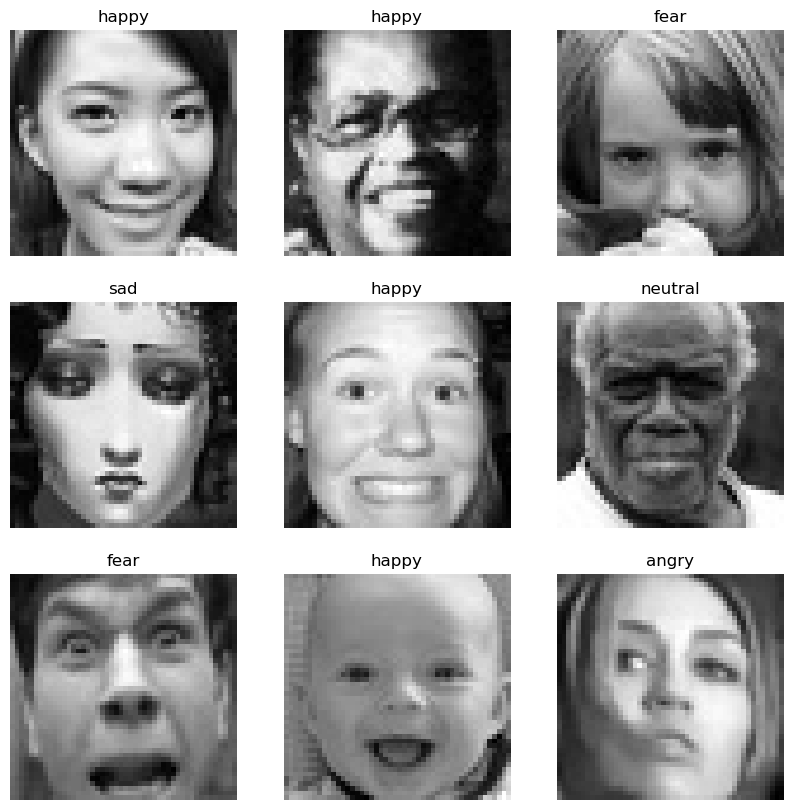

In [7]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis("off")
plt.show()

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims * 4)
        self.linear2 = nn.Linear(hidden_dims * 4, hidden_dims * 2)
        self.linear3 = nn.Linear(hidden_dims * 2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

img_height, img_width = 48, 48  # Assuming the image dimensions are 48x48
input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)  
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy 

In [10]:
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in tqdm(range(epochs)):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')

  2%|▎         | 1/40 [00:04<02:47,  4.30s/it]


EPOCH 1:	Training loss: 1.932	Validation loss: 1.914


  5%|▌         | 2/40 [00:08<02:37,  4.14s/it]


EPOCH 2:	Training loss: 1.899	Validation loss: 1.885


  8%|▊         | 3/40 [00:12<02:31,  4.10s/it]


EPOCH 3:	Training loss: 1.872	Validation loss: 1.860


 10%|█         | 4/40 [00:16<02:26,  4.08s/it]


EPOCH 4:	Training loss: 1.849	Validation loss: 1.841


 12%|█▎        | 5/40 [00:20<02:25,  4.17s/it]


EPOCH 5:	Training loss: 1.831	Validation loss: 1.826


 15%|█▌        | 6/40 [00:27<02:56,  5.18s/it]


EPOCH 6:	Training loss: 1.817	Validation loss: 1.814


 18%|█▊        | 7/40 [00:34<03:09,  5.76s/it]


EPOCH 7:	Training loss: 1.806	Validation loss: 1.806


 20%|██        | 8/40 [00:41<03:16,  6.13s/it]


EPOCH 8:	Training loss: 1.798	Validation loss: 1.799


 22%|██▎       | 9/40 [00:48<03:14,  6.28s/it]


EPOCH 9:	Training loss: 1.791	Validation loss: 1.793


 25%|██▌       | 10/40 [00:55<03:12,  6.41s/it]


EPOCH 10:	Training loss: 1.786	Validation loss: 1.788


 28%|██▊       | 11/40 [01:01<03:09,  6.55s/it]


EPOCH 11:	Training loss: 1.781	Validation loss: 1.784


 30%|███       | 12/40 [01:08<03:00,  6.44s/it]


EPOCH 12:	Training loss: 1.776	Validation loss: 1.780


 32%|███▎      | 13/40 [01:13<02:43,  6.07s/it]


EPOCH 13:	Training loss: 1.772	Validation loss: 1.776


 35%|███▌      | 14/40 [01:18<02:30,  5.79s/it]


EPOCH 14:	Training loss: 1.769	Validation loss: 1.772


 38%|███▊      | 15/40 [01:24<02:23,  5.76s/it]


EPOCH 15:	Training loss: 1.765	Validation loss: 1.768


 40%|████      | 16/40 [01:29<02:14,  5.62s/it]


EPOCH 16:	Training loss: 1.760	Validation loss: 1.763


 42%|████▎     | 17/40 [01:34<02:04,  5.43s/it]


EPOCH 17:	Training loss: 1.755	Validation loss: 1.757


 45%|████▌     | 18/40 [01:39<01:57,  5.33s/it]


EPOCH 18:	Training loss: 1.749	Validation loss: 1.750


 48%|████▊     | 19/40 [01:44<01:49,  5.21s/it]


EPOCH 19:	Training loss: 1.742	Validation loss: 1.743


 50%|█████     | 20/40 [01:50<01:46,  5.32s/it]


EPOCH 20:	Training loss: 1.734	Validation loss: 1.734


 52%|█████▎    | 21/40 [01:55<01:42,  5.38s/it]


EPOCH 21:	Training loss: 1.724	Validation loss: 1.724


 55%|█████▌    | 22/40 [02:01<01:38,  5.48s/it]


EPOCH 22:	Training loss: 1.714	Validation loss: 1.713


 57%|█████▊    | 23/40 [02:06<01:31,  5.37s/it]


EPOCH 23:	Training loss: 1.702	Validation loss: 1.703


 60%|██████    | 24/40 [02:11<01:24,  5.26s/it]


EPOCH 24:	Training loss: 1.691	Validation loss: 1.692


 62%|██████▎   | 25/40 [02:16<01:18,  5.24s/it]


EPOCH 25:	Training loss: 1.680	Validation loss: 1.682


 65%|██████▌   | 26/40 [02:21<01:11,  5.14s/it]


EPOCH 26:	Training loss: 1.670	Validation loss: 1.674


 68%|██████▊   | 27/40 [02:26<01:06,  5.12s/it]


EPOCH 27:	Training loss: 1.660	Validation loss: 1.667


 70%|███████   | 28/40 [02:31<01:01,  5.11s/it]


EPOCH 28:	Training loss: 1.653	Validation loss: 1.660


 72%|███████▎  | 29/40 [02:36<00:55,  5.08s/it]


EPOCH 29:	Training loss: 1.646	Validation loss: 1.655


 75%|███████▌  | 30/40 [02:41<00:50,  5.07s/it]


EPOCH 30:	Training loss: 1.639	Validation loss: 1.651


 78%|███████▊  | 31/40 [02:47<00:46,  5.15s/it]


EPOCH 31:	Training loss: 1.633	Validation loss: 1.646


 80%|████████  | 32/40 [02:53<00:43,  5.38s/it]


EPOCH 32:	Training loss: 1.628	Validation loss: 1.642


 82%|████████▎ | 33/40 [02:58<00:37,  5.33s/it]


EPOCH 33:	Training loss: 1.622	Validation loss: 1.638


 85%|████████▌ | 34/40 [03:02<00:30,  5.02s/it]


EPOCH 34:	Training loss: 1.617	Validation loss: 1.635


 88%|████████▊ | 35/40 [03:07<00:25,  5.10s/it]


EPOCH 35:	Training loss: 1.612	Validation loss: 1.632


 90%|█████████ | 36/40 [03:13<00:21,  5.30s/it]


EPOCH 36:	Training loss: 1.608	Validation loss: 1.628


 92%|█████████▎| 37/40 [03:19<00:16,  5.57s/it]


EPOCH 37:	Training loss: 1.602	Validation loss: 1.625


 95%|█████████▌| 38/40 [03:26<00:11,  5.77s/it]


EPOCH 38:	Training loss: 1.598	Validation loss: 1.622


 98%|█████████▊| 39/40 [03:32<00:05,  5.88s/it]


EPOCH 39:	Training loss: 1.593	Validation loss: 1.619


100%|██████████| 40/40 [03:37<00:00,  5.43s/it]


EPOCH 40:	Training loss: 1.589	Validation loss: 1.617


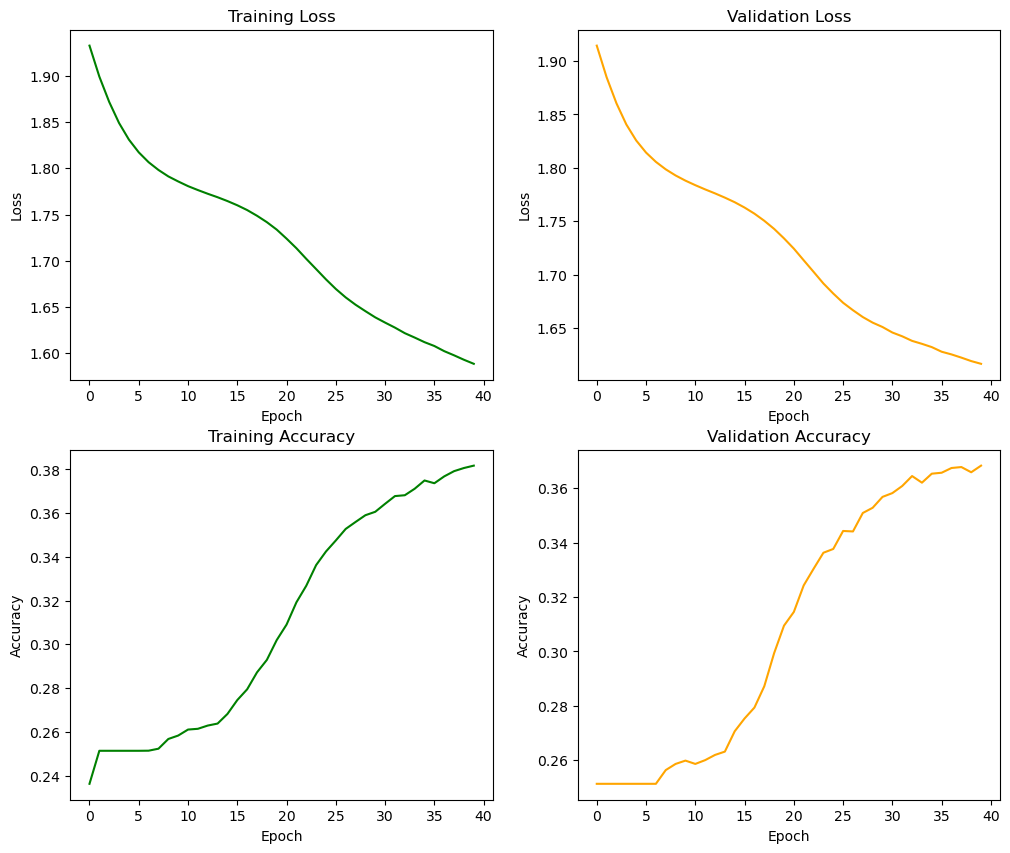

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [12]:
test_target = []
test_predict = []
model.eval()

with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())
        
    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    
    test_acc = compute_accuracy(test_predict, test_target)
    
    print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.383
